C:\Users\tiruu\AppData\Local\Temp\ipykernel_13972\43985316.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEV

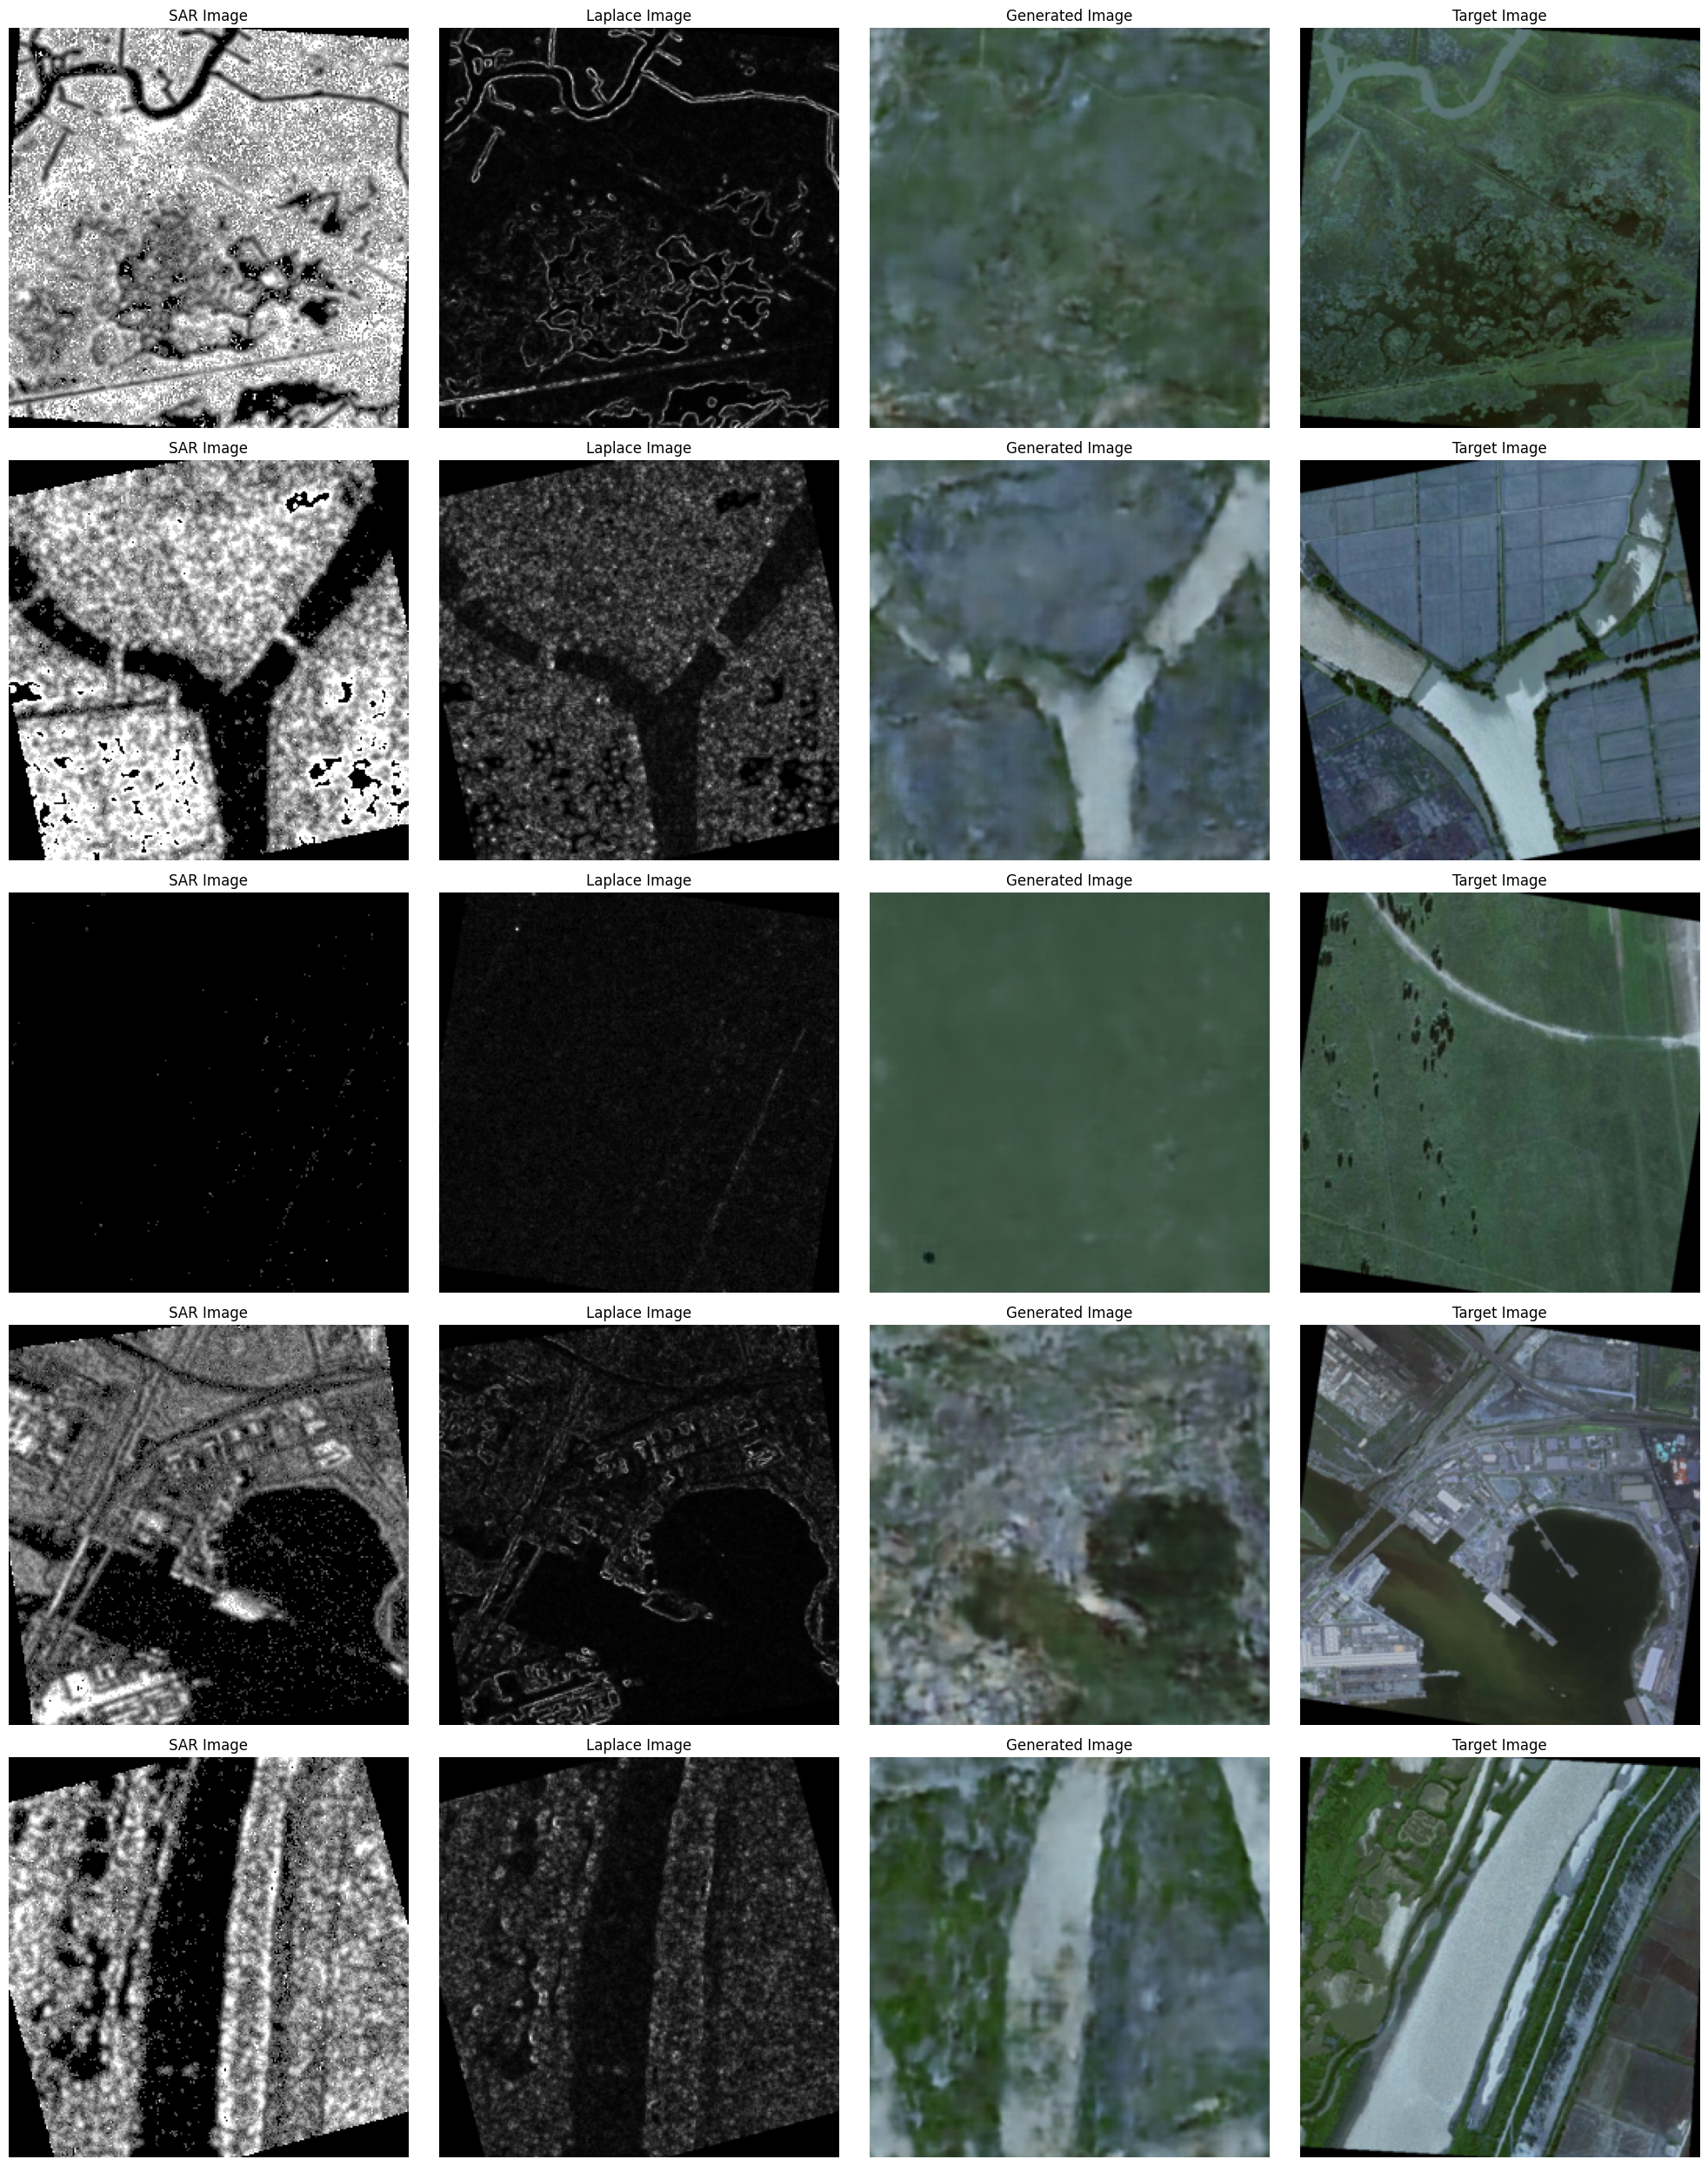

In [3]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Normalize
import os
import sys
import torch
import torch.nn as nn

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

class UNet(nn.Module):
    def __init__(self, input_channels=2, output_channels=3):
        super(UNet, self).__init__()
        
        def encoder_block(in_channels, out_channels, use_bn=True):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            return nn.Sequential(*layers)

        def decoder_block(in_channels, out_channels, dropout=0):
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels)
            ]
            if dropout != 0:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        def bottleneck_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
            )

        # Encoder
        self.enc1 = encoder_block(input_channels, 64, use_bn=False)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        self.enc5 = encoder_block(512, 512)
        self.enc6 = encoder_block(512, 512)
        self.enc7 = encoder_block(512, 512)

        self.bottleneck = bottleneck_block(512, 512)

        # Decoder
        self.dec1 = decoder_block(512, 512, dropout=0.5)
        self.dec2 = decoder_block(1024, 512, dropout=0.5)
        self.dec3 = decoder_block(1024, 512, dropout=0.5)
        self.dec4 = decoder_block(1024, 512)
        self.dec5 = decoder_block(1024, 256)
        self.dec6 = decoder_block(512, 128)
        self.dec7 = decoder_block(256, 64)
        self.final = nn.ConvTranspose2d(128, output_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)

        b = self.bottleneck(e7)

        # Decoder + Skip connections
        d1 = self.dec1(b)
        d2 = self.dec2(torch.cat([d1, e7], dim=1))
        d3 = self.dec3(torch.cat([d2, e6], dim=1))
        d4 = self.dec4(torch.cat([d3, e5], dim=1))
        d5 = self.dec5(torch.cat([d4, e4], dim=1))
        d6 = self.dec6(torch.cat([d5, e3], dim=1))
        d7 = self.dec7(torch.cat([d6, e2], dim=1))
        return torch.tanh(self.final(torch.cat([d7, e1], dim=1)))

from utils.helpers import *

# Путь к сохранённой модели
MODEL_PATH = "./saved_models/best_generator_pix2pix_450.pth"
DEVICE = torch.device("cpu")

# Загрузка модели
model = UNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# Since this is an evaluation, we should use @torch.no_grad()
@torch.no_grad()
def run_model():
    for sar, optical in train_loader:
        generated = model(sar)
        break

    fig, axes = plt.subplots(5, 4, figsize=(20, 25))

    for i in range(5):
        sar_image = sar[i].permute(1, 2, 0).cpu().detach().numpy()
        laplace_image = sar[i, 1].cpu().detach().numpy()
        generated_image = generated[i].permute(1, 2, 0).cpu().detach().numpy()
        optical_image = optical[i].permute(1, 2, 0).cpu().detach().numpy()

        axes[i, 0].imshow(sar_image[:, :, 0] * 0.5 + 0.5, cmap='gray')
        axes[i, 0].set_title('SAR Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(laplace_image * 0.5 + 0.5, cmap='gray')
        axes[i, 1].set_title('Laplace Image')
        axes[i, 1].axis('off')

        axes[i, 2].imshow((generated_image * 0.5 + 0.5))
        axes[i, 2].set_title('Generated Image')
        axes[i, 2].axis('off')

        axes[i, 3].imshow((optical_image * 0.5 + 0.5))
        axes[i, 3].set_title('Target Image')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

run_model()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data  = np.load('./logs/losses.npz')
train_loss = np.concatenate((prev_train_loss, data['train_losses']))
val_loss = np.concatenate((prev_val_loss, data['val_losses']))

# Построение графиков
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Generator Loss')
plt.plot(val_loss, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



# Построение графиков с использованием subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График для Train Loss
axes[0].plot(train_loss, label='Generator Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Generator Loss')
axes[0].legend()
axes[0].grid(True)

# График для Validation Loss
axes[1].plot(val_loss, label='Discriminator Loss', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Discriminator Loss')
axes[1].legend()
axes[1].grid(True)

# Отображение графиков
plt.tight_layout()
plt.show()


NameError: name 'prev_train_loss' is not defined